## Cluster analysis of TCGA breast cancer sets

Here we are perfoming a k-means analysis of two different datasets within the TCGA. 

First we retrieve the breast cancer RNAseq data as well as the clinical classification of the sets from cbioportal.org. The code for the retrieval of this data set is not important for the understanding of the analysis, but the code is kept for completness. Execute the code and proceed to next step.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import urllib.request
import tarfile
import gzip
import requests

def track_dl(url,tar):
    response = requests.get(url, stream=True)
    with open(tar, "wb") as handle:
        for data in response.iter_content():
            handle.write(data)

def get_tar(url,path):
    try:
        tf = tarfile.open(path)
    except:
        track_dl(url, path)
        tf = tarfile.open(path)
    return tf

def get_expression_data(path,url,file):
    df = get_data(path,url,file)
    df.dropna(axis=0, how='any', inplace=True)
    df.set_index('Hugo_Symbol', inplace=True)
    df.drop(columns=['Unnamed: 0', 'Entrez_Gene_Id'], inplace=True)
    #df.drop(columns=['Entrez_Gene_Id'], inplace=True)
    df = df.reindex(sorted(df.columns), axis=1)
    return df

def get_clinical_data(path,url,file):
    df = get_data(path,url,file).T
    df.columns = df.iloc[2]
    df.drop(columns=["A unique sample identifier.","STRING","1","SAMPLE_ID"], inplace=True)
#    df.drop(columns=["STRING","1"], inplace=True)
    df.drop(index=["Unnamed: 0","#Patient Identifier","Sample Identifier","Other Sample ID"], inplace=True)
    df = df.reindex(sorted(df.columns), axis=1)
    return df

def get_data(path,url,file):
    try:
        df = pd.read_csv(gzip.open(path,'rb'), sep="\t")
    except:
        urllib.request.urlretrieve(url, "my.tar.gz")
        tf = get_tar(url,"my.tar.gz")
        tf.extract(file)
        df = pd.read_csv(file, sep="\t")
        df.to_csv(gzip.open(path,'wb'), sep="\t")
    return df

brca = get_expression_data("../../data/brca.tsv.gz", 'http://download.cbioportal.org/brca_tcga_pub2015.tar.gz',"data_RNA_Seq_v2_expression_median.txt")
brca_clin = get_clinical_data("../../data/brca_clin.tsv.gz", 'http://download.cbioportal.org/brca_tcga_pub2015.tar.gz',"data_clinical_sample.txt")


Before any further analysis we clean our data. This includes removal of genes where no transcripts were found for any of the samples , i.e. their values are either [NaN](https://en.wikipedia.org/wiki/NaN) or zero. 

The data is also log transformed. It is generally assumed that expression values follow a log-normal distribution, and hence the log transformation implies that the new values follow a nomal distribution.

In [2]:
brca.dropna(axis=0, how='any', inplace=True)
brca = brca.loc[~(brca<=0.0).any(axis=1)]
brca = pd.DataFrame(data=np.log2(brca),index=brca.index,columns=brca.columns)

### Clustering with k-means

We first try to separate our data, just as it stands, into two clusters. This is done with k-means clustering with k=2.

In [3]:
from sklearn.cluster import KMeans
import numpy as np

X = brca.values.T
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
label_df = pd.DataFrame(columns=brca.columns,index=["kmeans_2"],data=[list(kmeans.labels_)])
brca_clin=brca_clin.append(label_df,sort=True)


We investigate the clusters to see what size they have.

In [4]:
label_df.loc["kmeans_2"].value_counts()

1    637
0    180
Name: kmeans_2, dtype: int64

Do we see any reason for the clustering's divide of the data? There is actually one appealing interpretation.

We can compare the clusters to wich patients that have been marked as [Progesterone receptor](https://en.wikipedia.org/wiki/Progesterone_receptor) Negative and [Estrogen receptor](https://en.wikipedia.org/wiki/Estrogen_receptor) Negative, i.e. the patologist did not fin that those receptors were expressed by the tumor. Such cancers are known to behave different than other cancers, and are less amendable to [hormonal theraphy](https://en.wikipedia.org/wiki/Hormonal_therapy_(oncology)).

In [5]:
brca_clin.loc["2N"]= (brca_clin.loc["PR status by ihc"]=="Negative") & (brca_clin.loc["ER Status By IHC"]=="Negative")
confusion_matrix = pd.crosstab(brca_clin.loc['2N'], brca_clin.loc['kmeans_2'], rownames=['PR-&ER-'], colnames=['Cluster'])
confusion_matrix

Cluster,0,1
PR-&ER-,,
False,41,614
True,139,23


So this time the cluster seem to reflect the different nature of the samples. Cluster 0 contains the bulk of all patients that are both ER- and PR-.

### Gausian Mixturte models

Another method to cluster data is Gausian Mixture Models (GMM). GMMs have a number of different applicats, however, here we use them for clustering. A key difference to k-Means, is that GMMs form their components (clusters) with different sense of distance in different feature directions directions.
Below we perform a GMM clustering for two separate components.

In [6]:
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture
gmm = GaussianMixture(n_components=2, covariance_type='diag', random_state=0).fit(X)
label_df = pd.DataFrame(columns=brca.columns,index=["GMM_2"],data=[list(gmm.predict(X))])
brca_clin=brca_clin.append(label_df,sort=True)


Again we compare our components to the explanation that the two clusters manage to capture the difference between tumors that are both ER- and PR- and other tumors.

In [7]:
confusion_matrix = pd.crosstab(brca_clin.loc['2N'], brca_clin.loc['GMM_2'], rownames=['PR-&ER-'], colnames=['Component'])
confusion_matrix

Component,0,1
PR-&ER-,,
False,238,417
True,151,11


The GMMs seem to have less clear separation between the two cases, with a fair number of the non ER-&PR- patients being included in cluster 0.

### Bayesian Gausian Mixture Models

A nice way to impement GMMs is in a Bayesian framework. An advantage of such models is the possibility not have to specify the number of components k, but instead let the algorithm select it for you, given an upper bound of k. The following exampe, taken from the [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html#sphx-glr-auto-examples-mixture-plot-gmm-py) makes a direct demonstration of why that is useful on a two dimensional feature space.

/home/lukask/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


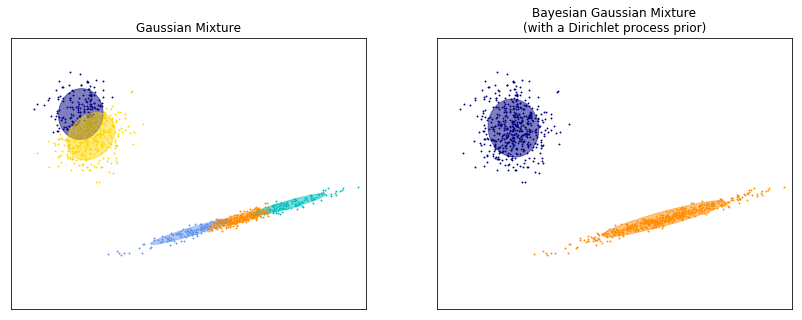

In [8]:
import itertools
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X_, Y_, means, covariances, index, title,f):
    splot = f.add_subplot(1, 2, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X_[Y_ == i, 0], X_[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)


fig = plt.figure(figsize=(14,5))

# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X_ = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

# Fit a Gaussian mixture with EM using five components
gmm = GaussianMixture(n_components=5, covariance_type='full').fit(X_)
plot_results(X_, gmm.predict(X_), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture',fig)

# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = BayesianGaussianMixture(n_components=5,
                                        covariance_type='full').fit(X_)
plot_results(X_, dpgmm.predict(X_), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture\n(with a Dirichlet process prior)',fig)

fig.show()

The GMM to the left tries to apply five different component to the data that seem to origin from two sources. The Bayesian implementation correctly recognizes that there are just two components, and sucessfully captures their spread.

We use the same technique, however instead of clustering our 20,000 dimensional data, we select a subset of 16 known cancer associated genes.

In [9]:
brca_names = ["ESR1", "SLC44A4", "SCUBE2", "FOXA1", "CA12", "NAT1", "BCAS1", "AFF3", "DNALI1", "CDCA7", "FOXC1", "SFRP1", "C1ORF106", "S100A9", "EN1", "PSAT1"]
Xlim = brca.loc[brca_names].values.T

In [10]:
bgmm = BayesianGaussianMixture(n_components=30, covariance_type='diag', random_state=0,max_iter=50,n_init=10).fit(Xlim)
label_df = pd.DataFrame(columns=brca.columns,index=["LimBGMM_30"],data=[list(bgmm.predict(Xlim))])
brca_clin=brca_clin.append(label_df,sort=True)


In [11]:
label_df.loc["LimBGMM_30"].value_counts()

2     254
12    135
24    114
13    114
25    112
22     67
10     13
7       4
18      2
20      1
1       1
Name: LimBGMM_30, dtype: int64

The algoritm clusters the data into 11 different clusters, where the bulk of the samples are in the 7 largest clusters.
The interpretation of this clustering is left to you as a reader.